In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.optimize import minimize

## SETTING GPU

In [3]:
# Check type of GPU available on machine
physical_devices = tf.config.list_physical_devices()
print("Available devices:", physical_devices)
# Use GPU if available
device_name = "GPU" if tf.config.experimental.list_physical_devices('GPU') else "cpu"
print("Using device:", device_name)

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using device: GPU


## HELPER FUNCTIONS

In [24]:
#this is meant for multidimentional data
def prepare_features_targets(data):
    features = data.loc[:, ~data.columns.get_level_values(0).str.contains('gain_loss')]
    targets = data.loc[:, data.columns.get_level_values(0).str.contains('gain_loss')]
    return features, targets

# Build and compile a neural network
def build_model(input_shape, output_shape):
    with tf.device(device_name):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal',input_shape=(input_shape,)),
            tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal'),
            tf.keras.layers.Dense(output_shape)
        ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Portfolio optimization function with variance consideration and risk aversion
def optimize_portfolio(weights, model, features, historical_returns, risk_aversion=0.8):
    weights = weights / np.sum(weights)  # Normalize weights
    pred_returns = model.predict(np.array([features.iloc[-1]]))[0]
    expected_return = np.dot(weights, pred_returns)
    covariance_matrix = historical_returns.cov()
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    # Objective function with risk aversion parameter
    return -expected_return + risk_aversion * portfolio_variance  # Maximize returns and penalize variance


## DATA

In [25]:
data_yf = pd.read_csv('data/all_stock_data.csv')

In [26]:
data_yf.set_index('Date', inplace=True)
#set index to datetime
data_yf.index = pd.to_datetime(data_yf.index)

In [27]:
#get symbols (TICKERS)
# this needs to execute before transorming the data into multindex
symbols = list(data_yf['Ticker'].value_counts().index)

In [28]:
data_yf = data_yf.pivot_table(index='Date', columns=['Ticker'], aggfunc='mean')

/var/folders/l3/h56ll3s97r3bp825gbh1f4q80000gq/T/ipykernel_19620/2531892422.py:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  data_yf = data_yf.pivot_table(index='Date', columns=['Ticker'], aggfunc='mean')


In [29]:
data = data_yf.copy()
#keep only float columns for model
float_columns = data.select_dtypes(include=['float64']).columns
data = data[float_columns]
data.dropna(inplace=True)

In [106]:
data_yf

Adj Close                                                    \
Ticker             A      AAPL       ABT      ACGL       ACN      ADBE   
Date                                                                     
2005-01-01 -0.358229 -0.430459 -0.354121 -0.412590 -0.328286 -0.269412   
2005-01-08 -0.360501 -0.430378 -0.356287 -0.412881 -0.329586 -0.270975   
2005-01-15 -0.361362 -0.430353 -0.356312 -0.412704 -0.334178 -0.274270   
2005-01-22 -0.362016 -0.430053 -0.357549 -0.413228 -0.332390 -0.278788   
2005-01-29 -0.359124 -0.429635 -0.357113 -0.411782 -0.331862 -0.254610   
...              ...       ...       ...       ...       ...       ...   
2023-12-02  0.284105  0.674437  0.151772  0.014270  1.465805  3.030413   
2023-12-09  0.338371  0.684994  0.167418 -0.019147  1.504839  2.886457   
2023-12-16  0.354174  0.662460  0.177210 -0.016760  1.562938  2.966420   
2023-12-23  0.351116  0.656387  0.183063 -0.014316  1.542970  2.954201   
2023-12-30       NaN       NaN       NaN       NaN       NaN       NaN   

                                                    ...  win                 \
Ticker           ADI       ADM       ADP      ADSK  ...  WRB  WST  WTW   WY   
Date                                                ...                       
2005-01-01 -0.308205 -0.356685 -0.314928 -0.241575  ... -1.0  1.0 -1.0  0.0   
2005-01-08 -0.307880 -0.356429 -0.315498 -0.256458  ...  1.0  0.0 -1.0 -1.0   
2005-01-15 -0.312100 -0.353692 -0.314272 -0.258502  ... -1.0  1.0 -1.0 -1.0   
2005-01-22 -0.311126 -0.352232 -0.313217 -0.274180  ... -1.0 -1.0 -1.0 -1.0   
2005-01-29 -0.301101 -0.348508 -0.310508 -0.258275  ...  1.0  1.0  1.0  1.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2023-12-02  0.609377 -0.021198  0.851294  0.836689  ... -1.0 -1.0 -1.0 -1.0   
2023-12-09  0.699882 -0.009938  0.886618  0.940579  ... -1.0  1.0 -1.0  1.0   
2023-12-16  0.678500 -0.034091  0.868705  0.943250  ... -1.0 -1.0  1.0  1.0   
2023-12-23  0.686759 -0.029812  0.880007  0.947342  ...  1.0 -1.0  0.0  1.0   
2023-12-30       NaN       NaN       NaN       NaN  ...  NaN  NaN  NaN  NaN   

                                          
Ticker     WYNN  XEL  XOM  YUM  ZBH ZBRA  
Date                                      
2005-01-01 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
2005-01-08 -1.0  1.0  1.0 -1.0 -1.0 -1.0  
2005-01-15 -1.0  0.0 -1.0  1.0  1.0  0.0  
2005-01-22 -1.0  0.0  1.0 -1.0  0.0 -1.0  
2005-01-29  1.0  1.0  1.0  1.0  1.0  1.0  
...         ...  ...  ...  ...  ...  ...  
2023-12-02  0.0  0.0 -1.0 -1.0  0.0 -1.0  
2023-12-09  1.0  1.0  1.0  1.0  1.0  1.0  
2023-12-16  1.0  0.0  0.0  0.0  1.0 -1.0  
2023-12-23  1.0  0.0 -1.0  1.0  1.0  1.0  
2023-12-30  NaN  NaN  NaN  NaN  NaN  NaN  

[992 rows x 18659 columns]

In [30]:
split_date_train = pd.Timestamp('2020-01-01')
split_date_val = pd.Timestamp('2021-12-31')

train_data = data.loc[data.index < split_date_train]
val_data = data.loc[(data.index >= split_date_train) & (data.index < split_date_val)]
test_data = data.loc[data.index >= split_date_val]

# Prepare features and targets for each dataset
features_train, targets_train = prepare_features_targets(train_data)
features_val, targets_val = prepare_features_targets(val_data)
features_test, targets_test = prepare_features_targets(test_data)

# Convert data to PyTorch tensors and create DataLoader objects
features_train = torch.tensor(features_train.values.astype(np.float32))
targets_train = torch.tensor(targets_train.values.astype(np.float32))
features_val = torch.tensor(features_val.values.astype(np.float32))
targets_val = torch.tensor(targets_val.values.astype(np.float32))
features_test = torch.tensor(features_test.values.astype(np.float32))
targets_test = torch.tensor(targets_test.values.astype(np.float32))

train_dataset = TensorDataset(features_train, targets_train)
val_dataset = TensorDataset(features_val, targets_val)
test_dataset = TensorDataset(features_test, targets_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Training Features shape:", features_train.shape)
print("Training Targets shape:", targets_train.shape)
print("Validation Features shape:", features_val.shape)
print("Validation Targets shape:", targets_val.shape)
print("Test Features shape:", features_test.shape)
print("Test Targets shape:", targets_test.shape)


Training Features shape: torch.Size([783, 18262])
Training Targets shape: torch.Size([783, 397])
Validation Features shape: torch.Size([104, 18262])
Validation Targets shape: torch.Size([104, 397])
Test Features shape: torch.Size([104, 18262])
Test Targets shape: torch.Size([104, 397])


In [31]:
features_train = features_train[:, None, :]  # Add a time step dimension
print("New features shape:", features_train.shape)

features_val = features_val[:, None, :]  # Add a time step dimension
print("New features shape:", features_val.shape)

features_test = features_test[:, None, :]  # Add a time step dimension
print("New features shape:", features_test.shape)

New features shape: torch.Size([783, 1, 18262])
New features shape: torch.Size([104, 1, 18262])
New features shape: torch.Size([104, 1, 18262])


In [32]:
# Print the shape of the training and testing data to confirm
print("Training features shape:", features_train.shape)
print("Training targets shape:", targets_train.shape)
print("Validation features shape:", features_val.shape)
print("Validation targets shape:", targets_val.shape)
print("Testing features shape:", features_test.shape)
print("Testing targets shape:", targets_test.shape)


Training features shape: torch.Size([783, 1, 18262])
Training targets shape: torch.Size([783, 397])
Validation features shape: torch.Size([104, 1, 18262])
Validation targets shape: torch.Size([104, 397])
Testing features shape: torch.Size([104, 1, 18262])
Testing targets shape: torch.Size([104, 397])


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

def build_model(num_features, num_time_steps, output_shape):
    model = Sequential()
    # Add a LSTM layer only if your data is sequenced; otherwise start with Dense
    model.add(LSTM(64, activation = 'relu', input_shape=(num_time_steps, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation = 'relu', return_sequences=False))
    model.add(Dense(output_shape, activation='sigmoid'))  # Sigmoid or softmax based on your needs
    model.compile(optimizer='adam', loss='mse')
    return model

# Example usage assuming you've correctly shaped your data
num_features = features_train.shape[2]  # number of features per timestep
num_time_steps = features_train.shape[1]  # number of timesteps per sample
output_shape = targets_train.shape[1]  # assuming this is a regression task or multi-label classification

from tensorflow.keras.backend import clear_session
clear_session()
# Now define and compile your model again
model = build_model(num_features, num_time_steps, output_shape)


/Users/MV/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
# Train the model
history = model.fit(
    features_train, targets_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.3312 - val_loss: 0.7958
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.2644 - val_loss: 0.7023
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.1522 - val_loss: 0.6337
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.1160 - val_loss: 0.6056
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0506 - val_loss: 0.5933
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0620 - val_loss: 0.5789
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.1369 - val_loss: 0.5658
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9523 - val_loss: 0.5566
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9502 - val_loss: 0.5563
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9056 - val_loss: 0.5466


In [35]:
# Evaluate the model on the test set
val_loss = model.evaluate(features_val, targets_val, verbose=1)
print("Validation loss:", val_loss)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5135
Validation loss: 1.1915425062179565


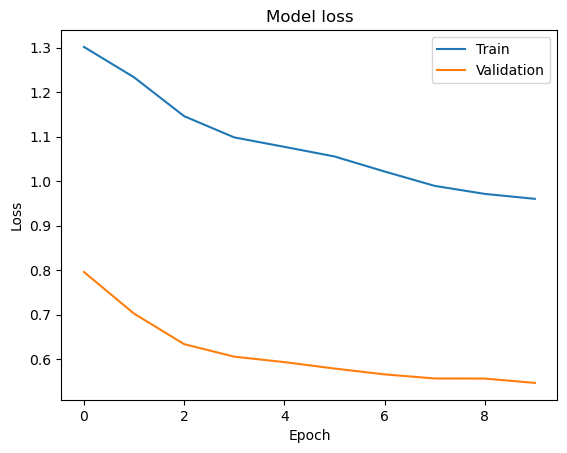

In [36]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [37]:
# Make predictions
predictions = model.predict(features_val)
predictions

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[0.06318396, 0.07797826, 0.05831984, ..., 0.07010267, 0.07722056,
        0.07111147],
       [0.34888512, 0.35449427, 0.276049  , ..., 0.31110612, 0.28318927,
        0.32426363],
       [0.03704553, 0.0493429 , 0.03465981, ..., 0.04560534, 0.04959429,
        0.04521822],
       ...,
       [0.04568898, 0.05947804, 0.04244432, ..., 0.05414167, 0.05909326,
        0.05395456],
       [0.29131502, 0.30035597, 0.25191402, ..., 0.29271623, 0.27917913,
        0.30451345],
       [0.17980929, 0.1979846 , 0.15998513, ..., 0.18687645, 0.19110239,
        0.18944158]], dtype=float32)

In [38]:
# Saving the model
model.save('my_lstm_model.h5')

In [42]:
# Define the optimization function for the portfolio on the validation set
def optimize_portfolio_val(weights, model, features_val, predictions_val, risk_aversion=0.8):
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Predict returns using the provided model
    pred_returns = predictions_val
    
    # Calculate the covariance matrix from historical returns (you may not have this, so let's assume it's the identity matrix for simplicity)
    num_assets = len(weights)
    covariance_matrix = np.eye(num_assets)
    
    # Portfolio variance
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))

    # Objective function: Maximize returns and minimize variance
    objective = -np.dot(weights, pred_returns) + risk_aversion * portfolio_variance
    return objective

# Number of assets
num_assets = targets_val.shape[1]

# Initial guess for weights
initial_weights = np.ones(num_assets) / num_assets

# Constraints: sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds for weights
bounds = tuple((0, 1) for asset in range(num_assets))

risk_aversion = 0.8
# Calculate the average predicted returns across all samples in the validation set
average_pred_returns = np.mean(predictions, axis=0)

# Now use average_pred_returns instead of predictions_val in the optimization function
result_val = minimize(optimize_portfolio_val, initial_weights, args=(model, features_val, average_pred_returns, risk_aversion),
                      method='SLSQP', bounds=bounds, constraints=constraints)

print("Optimized weights on validation set:", result_val.x)


Optimized weights on validation set: [0.00000000e+00 4.11380075e-03 7.12079423e-17 2.08911559e-18
 1.80967302e-03 2.57604526e-04 2.20181452e-17 0.00000000e+00
 0.00000000e+00 7.34618583e-03 3.23584076e-18 0.00000000e+00
 7.40448428e-04 0.00000000e+00 1.01168589e-02 0.00000000e+00
 0.00000000e+00 1.10978272e-02 5.56464725e-03 1.02900903e-02
 1.81030560e-17 1.55678838e-03 6.52978832e-03 9.58596963e-18
 0.00000000e+00 9.98065609e-18 1.20581669e-02 4.02817572e-03
 0.00000000e+00 3.87523675e-03 3.15727889e-04 6.61947427e-18
 0.00000000e+00 0.00000000e+00 1.36357406e-17 3.20258488e-03
 0.00000000e+00 5.56744032e-03 8.85789142e-03 7.54781934e-03
 4.71451098e-17 1.39593129e-03 1.20608813e-17 5.67497069e-17
 2.55241846e-17 7.38529541e-03 6.77535619e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.63951253e-03 2.42937585e-17
 1.55747381e-02 4.38449489e-03 4.51025043e-19 2.89964845e-04
 0.00000000e+00 5.80087366e-04 0.00000000e+00 0.00000000e+00
 2.27332295e-03 1.52905097e-17 0.00000000e+00 2.

In [91]:
tickers = data.columns.get_level_values('Ticker').unique()

In [92]:
# Zip result.x with tickers to create a list of tuples containing ticker symbols and corresponding weights
ticker_weights = zip(tickers, result.x)

# Convert the zipped result to a dictionary for easier manipulation
ticker_weights_dict = dict(ticker_weights)

# Print the non-zero weights
print_non_zero_weights(result.x, "Optimized Portfolio Weights (Test)", symbols)

# Display the ticker symbols with non-zero weights
print("Optimized Portfolio Weights with Tickers:")
for ticker, weight in ticker_weights_dict.items():
    print(f"{ticker}: Weight {weight}")


Optimized Portfolio Weights (Test) (non-zero weights):
AAPL: Weight 0.010689431248031556
EQR: Weight 0.01495426249499892
DTE: Weight 0.010388681112914327
ILMN: Weight 0.010491161465071596
TYL: Weight 0.017970350126053594
HSY: Weight 0.014494341548389208
PPG: Weight 0.013501863660149258
GLW: Weight 0.01886126029644321
CPT: Weight 0.01377711765172682
IP: Weight 0.011104984694490179
AKAM: Weight 0.011892662798594538
FDS: Weight 0.015733276778723253
JBL: Weight 0.011956491758710117
SWK: Weight 0.026119055768573422
ADI: Weight 0.011404502929237741
MO: Weight 0.014961569136337529
CB: Weight 0.019797934973220733
DVN: Weight 0.011681952918956951
HD: Weight 0.04764353084206584
D: Weight 0.013861951097060387
COR: Weight 0.015784540363489755
PWR: Weight 0.01045167941615859
YUM: Weight 0.010278368999495342
KMB: Weight 0.010810526099874195
BDX: Weight 0.013589667169493988
MSI: Weight 0.029827102623244024
Optimized Portfolio Weights with Tickers:
A: Weight 0.005119791652255823
AAPL: Weight 0.0106894

In [105]:
# Step 1: Extract Opening Prices
get_prices = pd.read_csv('data/raw_data_yf.csv')

# Filter the DataFrame for the specified date and select 'Ticker' and 'Open' columns
opening_prices = get_prices[get_prices['Date'] == '2022-01-01'][['Ticker', 'Open']]

# Step 2: Calculate Allocation
initial_investment = 10000  # Initial investment amount
proposed_weights = result.x  # Proposed weights from optimization

# Merge the opening prices DataFrame with the ticker weights to ensure alignment
merged_data = pd.merge(opening_prices, pd.DataFrame(ticker_weights_dict.items(), columns=['Ticker', 'Weight']), on='Ticker')

# Calculate allocation for each asset
merged_data['Allocation'] = (initial_investment * merged_data['Weight']) / merged_data['Open']

# Step 3:  Evaluate Portfolio Value
# Assuming closing_prices is a DataFrame containing closing prices for each ticker on 12-31-2023
closing_prices = get_prices[get_prices['Date'] == '2023-12-23'][['Ticker', 'Close']]

# Merge the allocation data with the closing prices
merged_data = pd.merge(merged_data, closing_prices, on='Ticker')

# Calculate the total value of the portfolio
portfolio_value = (merged_data['Allocation'] * merged_data['Close']).sum()

# Step 4: Calculate Profit
profit = portfolio_value - initial_investment

# Step 5: Compare
print("Profit/Loss from optimized portfolio:", profit)


Profit/Loss from optimized portfolio: 29.15335306770976


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pyepo
from pyepo.model.grb import optGrbModel
import torch
from torch import nn
from torch.utils.data import DataLoader

m = targets_val.shape[1] # total number of assets
cov = np.cov(np.random.randn(10, m), rowvar=False) # covariance matrix
optmodel = pyepo.model.grb.portfolioModel(m, cov) # build model

In [ ]:
import torch.nn.functional as F
from torch import nn
import torch 

def build_model(num_features, num_time_steps, output_shape):
    model = Sequential()
    # Add a LSTM layer only if your data is sequenced; otherwise start with Dense
    model.add(LSTM(64, activation = 'relu', input_shape=(num_time_steps, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation = 'relu', return_sequences=False))
    model.add(Dense(output_shape, activation='sigmoid'))  # Sigmoid or softmax based on your needs
    return model

# Example usage assuming you've correctly shaped your data
num_features = features_train.shape[2]  # number of features per timestep
num_time_steps = features_train.shape[1]  # number of timesteps per sample
output_shape = targets_train.shape[1]  # assuming this is a regression task or multi-label classification
lstm = build_model(num_features, num_time_steps,output_shape)

spop = pyepo.func.SPOPlus(optmodel, processes=1)

In [ ]:
import time

# train model
def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    train_loss_log = []
    loss_log_regret = [pyepo.metric.regret(reg, optmodel, val_loader)] #use val_loader
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        train_loss = 0
        for i, data in enumerate(train_loader): #train_loader
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            elif method_name == "mse":
                loss = loss_func(cp, c)
            else:
                raise ValueError("Method name {} not supported".format(method_name))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            train_loss += loss.item()
        train_loss /= len(train_loader) #training still
        train_loss_log.append(train_loss)
        regret = pyepo.metric.regret(reg, optmodel, val_loader) #regret calculated on val set
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, train_loss, regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return train_loss_log, loss_log_regret


In [ ]:
method_name = "spo+"

# Instantiate the model
loss_log_lstm_spo, loss_log_regret_lstm_spo = trainModel(lstm, loss_func=spop, method_name=method_name)


In [ ]:
###QUESTION FOR HYUNGKI: HOW DO I GET THE PREDICTIONS AFTER THIS. RUN MODEL ON TEST_LOADER
#need to see what weights we decided to assign after the training with NN, which isn't shown in the documentation or lab code
#thoughts: optmodel.solve?
# Then how do I use it to evaluate, just multiply?